In [1]:
import pandas as pd
from pandas import Timestamp as tmpstemp
from pandas import Timedelta as tmpdelta
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from portfolio import Portfolio, Asset
from strategies import LSTM_Strategy, Rebalancing_Strategy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_190402/3158763181.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-27 21:31:45.096087: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
USD = Asset.make_USD()
BTC = Asset('BTC')
#BTC.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2020-01-01'), date_to = tmpstemp('2024-03-31'))
ETH = Asset('ETH')
#ETH.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2020-01-01'), date_to = tmpstemp('2024-03-31'))
USDT = Asset('USDT')
#USDT.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2021-01-01'), date_to = tmpstemp('2024-03-31'))

In [3]:
naive_LSTM = LSTM_Strategy(model_input_length = 15)
date_from = tmpstemp('2022-01-01')
x_train, y_train, train_idx, x_val, y_val, val_idx = naive_LSTM.train_val_split_scale(BTC.history.loc[date_from:])

rebalncer = Rebalancing_Strategy(target_allocations = {'USD':0.5, 'BTC':0.5})

2024-04-27 21:31:47.395525: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
hidden_size = 50
dropout = 0.2
learning_rate = 0.0005

input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]), name = 'input')

LSTM1 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM1' )(input_layer)
LSTM1 = Dropout(dropout)(LSTM1)

LSTM2 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM2' )(LSTM1)
LSTM2 = Dropout(dropout)(LSTM2)

LSTM3 = LSTM(units = 50, activation='tanh', name = 'LSTM3' )(LSTM2)
LSTM3 = Dropout(dropout)(LSTM3)
'''
hidden1 = Dense(hidden_size, activation='relu', name='hidden_layer1')(LSTM3)
hidden1 = Dropout(dropout)(hidden1)
'''

# Create output layer
out = Dense(1, activation='linear', name = 'Regression_layer')(LSTM3)
model = Model(inputs=[input_layer], outputs=out)

model.compile(optimizer=Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.metrics.mean_squared_error])
naive_LSTM.model = model
#naive_LSTM.model.summary()

#Set up early stopping monitor
early_stopping = EarlyStopping(monitor='val_mean_squared_error',
                               patience=5,
                               mode = "auto",
                               restore_best_weights=True)

naive_LSTM.model.fit([x_train], y_train, 
          validation_data=([x_val], y_val),
          epochs=20, batch_size=64,
          callbacks=[early_stopping])

2024-04-27 21:31:47.893805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-27 21:31:47.895904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-27 21:31:47.897813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-04-27 21:31:48.360434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-27 21:31:48.362177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-27 21:31:48.363558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - ETA: 0s - loss: 0.0247 - mean_squared_error: 0.0247

2024-04-27 21:31:56.526014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-27 21:31:56.528103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-27 21:31:56.530367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 9s 340ms/step - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0368 - val_mean_squared_error: 0.0368
Epoch 2/20
9/9 [==============================] - 1s 137ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0144 - val_mean_squared_error: 0.0144
Epoch 3/20
9/9 [==============================] - 2s 172ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0311 - val_mean_squared_error: 0.0311
Epoch 4/20
9/9 [==============================] - 1s 165ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 5/20
9/9 [==============================] - 1s 155ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 6/20
9/9 [==============================] - 1s 164ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 7/20
9/9 [==============================] - 1

In [5]:
my_portfolio = Portfolio(origination_date=(date_from - tmpdelta(days=1)),
                         initial_deposit= 0.5* BTC.price_on_date(date_from - tmpdelta(days=1)))
my_portfolio.update_transactions(ticker='BTC',
                                qty = 0.5,
                                transaction_date=(date_from - tmpdelta(days=1)),
                                note = 'Initial deposit' )

buy_n_hold_portfolio = Portfolio(origination_date=(date_from - tmpdelta(days=1)),
                         initial_deposit= 0.5* BTC.price_on_date(date_from - tmpdelta(days=1)))
buy_n_hold_portfolio.update_transactions(ticker='BTC',
                                qty = 0.5,
                                transaction_date=(date_from - tmpdelta(days=1)),
                                note = 'Initial deposit' )

rebal_portfolio = Portfolio(origination_date=(date_from - tmpdelta(days=1)),
                         initial_deposit= 0.5* BTC.price_on_date(date_from - tmpdelta(days=1)))
rebal_portfolio.update_transactions(ticker='BTC',
                                qty = 0.5,
                                transaction_date=(date_from - tmpdelta(days=1)),
                                note = 'Initial deposit' )

In [6]:
#pred_df = naive_LSTM.predict_batch(data_to_process = BTC.history['close'].loc[val_idx[0]-tmpdelta(days=14):])

In [7]:
def execute_suggestions(suggestions, portfolio, today_date):
    for ticker in suggestions.index:
        portfolio.update_transactions(ticker = str(ticker),
                                    qty =  suggestions['change_in_size'].loc[ticker],
                                    transaction_date = today_date,
                                    note =  suggestions['note'].loc[ticker])

pred_df = pd.DataFrame(data=[],
                        columns = ['Predicted price'],
                        index = pd.DatetimeIndex([], name='date_time'))


#Find record in BTC history that is closest to the origin date of the portfolio
first_index = BTC.history.index.get_indexer([my_portfolio.orig_date], method='nearest')[0] + 1
first_date = BTC.history.index[first_index]

alloc_exp = []
alloc_rebal = []
alloc_bnh = []
for today in BTC.history.index[first_index:-2]:
    tmr = today + tmpdelta(days=1)
    alloc_exp.append(my_portfolio.get_positions(today)['allocation'].loc['BTC'])
    today_data = BTC.history['close'].\
                        loc[today-tmpdelta(days=(naive_LSTM.input_span-1)):today]
    new_pred = naive_LSTM.predict_one(today_data)
    pred_df = pd.concat([pred_df, new_pred], axis = 0)
    suggestion = naive_LSTM.make_suggestion(today, my_portfolio)
    execute_suggestions(suggestion, my_portfolio, today)

    alloc_rebal.append(rebal_portfolio.get_positions(today)['allocation'].loc['BTC'])
    rebal_suggest = rebalncer.make_suggestion(today , rebal_portfolio)
    execute_suggestions(rebal_suggest, rebal_portfolio, today)

    alloc_bnh.append(buy_n_hold_portfolio.get_positions(today)['allocation'].loc['BTC'])

my_portfolio.update_value(up_to=pred_df.index[-1])
buy_n_hold_portfolio.update_value(up_to=pred_df.index[-1])
rebal_portfolio.update_value(up_to=pred_df.index[-1])

2024-04-27 21:32:14.358229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-27 21:32:14.360322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-27 21:32:14.362695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

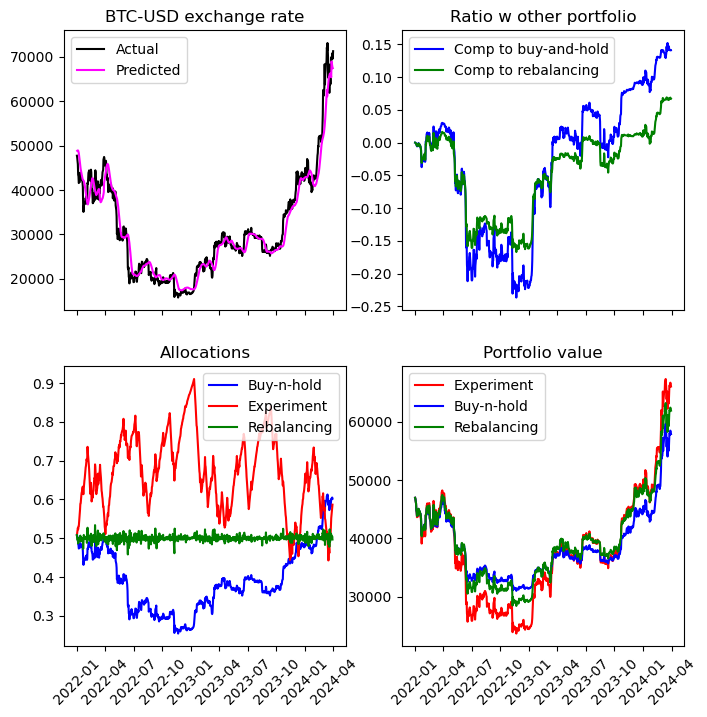

In [9]:
# Plot the results
fig, ax = plt.subplots(2, 2, sharex = True)
fig.set_figheight(8)
fig.set_figwidth(8)
actual_df = BTC.history.loc[first_date:]
ax[0,0].plot(actual_df.index, actual_df['close'], color = 'black', label = 'Actual')
ax[0,0].plot(pred_df.index, pred_df['Predicted price'], color = 'magenta', label = 'Predicted')
ax[0,0].legend()
ax[0,0].set_title('BTC-USD exchange rate')
for tick in ax[0,0].get_xticklabels():
        tick.set_rotation(45)

ax[0,1].plot(my_portfolio.value.index, (my_portfolio.value['value'] - buy_n_hold_portfolio.value['value'])/buy_n_hold_portfolio.value['value'], color = 'blue', label = 'Comp to buy-and-hold')
ax[0,1].plot(my_portfolio.value.index, (my_portfolio.value['value'] - rebal_portfolio.value['value'])/rebal_portfolio.value['value'], color = 'green', label = 'Comp to rebalancing')
ax[0,1].legend()
ax[0,1].set_title('Ratio w other portfolio')
for tick in ax[0,1].get_xticklabels():
        tick.set_rotation(45)

ax[1,0].plot(buy_n_hold_portfolio.value.index[:-1], alloc_bnh, color = 'blue', label = 'Buy-n-hold')
ax[1,0].plot(my_portfolio.value.index[:-1], alloc_exp, color = 'red', label = 'Experiment')
ax[1,0].plot(rebal_portfolio.value.index[:-1], alloc_rebal, color = 'green', label = 'Rebalancing')
ax[1,0].legend()
ax[1,0].set_title('Allocations')
for tick in ax[1,0].get_xticklabels():
        tick.set_rotation(45)

ax[1,1].plot(my_portfolio.value.index, my_portfolio.value['value'], color = 'red', label = 'Experiment')
ax[1,1].plot(buy_n_hold_portfolio.value.index, buy_n_hold_portfolio.value['value'], color = 'blue', label = 'Buy-n-hold')
ax[1,1].plot(rebal_portfolio.value.index, rebal_portfolio.value['value'], color = 'green', label = 'Rebalancing')
ax[1,1].legend()
ax[1,1].set_title('Portfolio value')
for tick in ax[1,1].get_xticklabels():
        tick.set_rotation(45)